In [1]:
%matplotlib notebook
from glob import glob
from astropy.time import Time
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii, fits
# import seaborn as sns

In [2]:
from matplotlib.pyplot import cycler
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm

def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = matplotlib.cm.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

#prop_cycle = plt.rcParams['axes.prop_cycle']
#plt.rcParams["axes.prop_cycle"] =
prop_cycle= get_cycle("tab20")
colors = prop_cycle.by_key()['color'] 

In [3]:
ztf_fp = pd.read_csv('fps.txt', comment='#', index_col='index,', delim_whitespace=True)
ztf_fp.columns = [x.split(',')[0] for x in ztf_fp.columns]
ztf_fp.index.name = 'index'

In [4]:
ztf_fp.columns

Index(['field', 'ccdid', 'qid', 'filter', 'pid', 'infobitssci', 'sciinpseeing',
       'scibckgnd', 'scisigpix', 'zpmaginpsci', 'zpmaginpsciunc',
       'zpmaginpscirms', 'clrcoeff', 'clrcoeffunc', 'ncalmatches', 'exptime',
       'adpctdif1', 'adpctdif2', 'diffmaglim', 'zpdiff', 'programid', 'jd',
       'rfid', 'forcediffimflux', 'forcediffimfluxunc', 'forcediffimsnr',
       'forcediffimchisq', 'forcediffimfluxap', 'forcediffimfluxuncap',
       'forcediffimsnrap', 'aperturecorr', 'dnearestrefsrc', 'nearestrefmag',
       'nearestrefmagunc', 'nearestrefchi', 'nearestrefsharp', 'refjdstart',
       'refjdend', 'procstatus'],
      dtype='object')

In [5]:
ztf_fp['mjd'] = Time(ztf_fp['jd'],format='jd').mjd
# ztf_fp['ra'] = 284.67325
# ztf_fp['dec'] = 22.65816667
# ztf_fp['bjd'] = apply_barycenter(ztf_fp)

In [7]:
# check for nonzero procstatus
wfp_bad = (ztf_fp.procstatus.apply(lambda x: str(x)) != '0')
np.sum(wfp_bad)
ztf_fp.loc[wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

,,,ccdid
field,filter,procstatus,
489,ZTF_g,57,11
1483,ZTF_g,57,7


In [8]:
ztf_fp.loc[~wfp_bad,['field','filter','ccdid','procstatus']].groupby(['field','filter','procstatus']).agg(len)

,,,ccdid
field,filter,procstatus,
489,ZTF_r,0,13


In [9]:
len(ztf_fp)

31

<IPython.core.display.Javascript object>


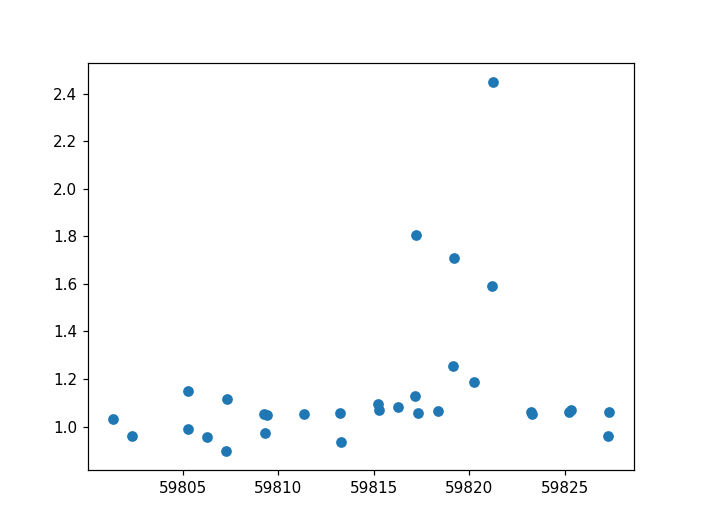

1.06307137382558


In [10]:
plt.figure()
plt.scatter(ztf_fp['mjd'],ztf_fp['forcediffimchisq'])
print(ztf_fp['forcediffimchisq'].median())

<IPython.core.display.Javascript object>


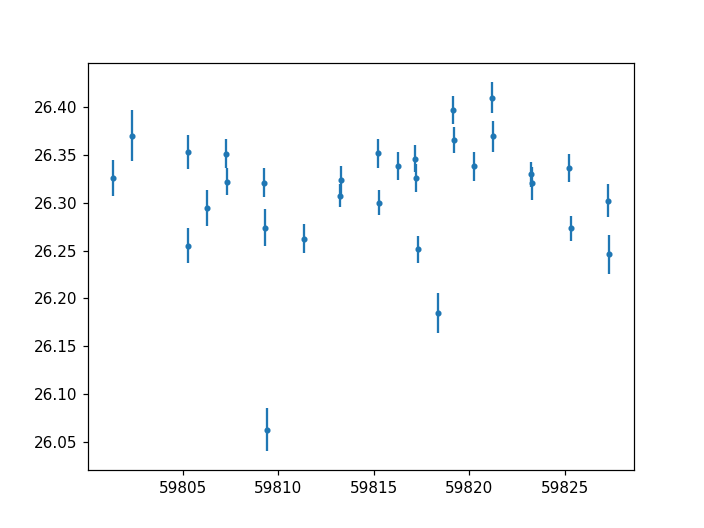

<ErrorbarContainer object of 3 artists>

In [12]:
plt.figure()
plt.errorbar(ztf_fp['mjd'],ztf_fp['zpmaginpsci'],ztf_fp['zpmaginpscirms'],fmt='.')

In [14]:
# TODO: need to check that nearest ref source is coincident and stellar
ztf_fp.loc[:,'nearestrefflux'] = 10**(0.4 * (ztf_fp['zpdiff'] - ztf_fp['nearestrefmag'])) 
ztf_fp.loc[:,'nearestreffluxunc'] = ztf_fp['nearestrefmagunc'] * ztf_fp['nearestrefflux']/ 1.0857
ztf_fp.loc[:,'dc_flux'] = ztf_fp['forcediffimflux'] + ztf_fp['nearestrefflux']
ztf_fp.loc[:,'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. - ztf_fp['nearestreffluxunc']**2.)
# fix any imaginary ones
ztf_fp.loc[ztf_fp.loc[:,'dc_flux_err'].isna(),'dc_flux_err'] = np.sqrt(ztf_fp['forcediffimfluxunc']**2. + ztf_fp['nearestreffluxunc']**2.)
ztf_fp.loc[:,'dc_snr'] = ztf_fp['dc_flux']/ztf_fp['dc_flux_err']
SNT = 3 # 3-sigma detection
SNU = 5 # 5-sigma upper limit

ztf_fp.loc[:,'dc_mag'] = np.NaN
ztf_fp.loc[:,'dc_mag_err'] = np.NaN
ztf_fp.loc[:,'dc_maglim'] = np.NaN

wzdet = ztf_fp['dc_snr'] > SNT
ztf_fp.loc[wzdet,'dc_mag'] = ztf_fp.loc[wzdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wzdet,'dc_flux'])
ztf_fp.loc[wzdet,'dc_mag_err'] = 1.0857 / ztf_fp['dc_snr']

ztf_fp.loc[~wzdet,'dc_maglim'] = ztf_fp.loc[~wzdet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[~wzdet,'dc_flux_err'])


# if we don't have reference sources the calculation is slightly different
wnoref = ztf_fp['nearestrefmag'].isna()
wnorefdet = wnoref & ((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)
wnorefnondet = wnoref & ~((ztf_fp.loc[wnoref,'forcediffimflux'] / ztf_fp.loc[wnoref,'forcediffimfluxunc']) > SNT)

ztf_fp.loc[wnorefdet,'dc_mag'] = ztf_fp.loc[wnorefdet,'zpdiff'] - 2.5 * np.log10(ztf_fp.loc[wnorefdet,'forcediffimflux'])
ztf_fp.loc[wnorefdet,'dc_mag_err'] = 1.0857 / (ztf_fp['forcediffimflux'] / ztf_fp.loc[wnorefdet,'forcediffimfluxunc'])
ztf_fp.loc[wnorefnondet,'dc_maglim'] = ztf_fp.loc[wnorefnondet,'zpdiff'] - 2.5 * np.log10(SNU*ztf_fp.loc[wnorefnondet,'forcediffimfluxunc'])



In [15]:
ztf_fp

,field,ccdid,qid,filter,pid,infobitssci,sciinpseeing,scibckgnd,scisigpix,zpmaginpsci,...,procstatus,mjd,nearestrefflux,nearestreffluxunc,dc_flux,dc_flux_err,dc_snr,dc_mag,dc_mag_err,dc_maglim
index,,,,,,,,,,,,,,,,,,,,,
0,489,2,1,ZTF_r,2047338130515,0,1.3346,278.472,20.03700,26.3258,...,0,59801.338137,38.328339,6.142701,39.934558,53.212777,0.750469,NaN,NaN,20.263335
1,1483,11,0,ZTF_g,2048343124015,4194304,2.0550,494.135,24.14580,26.3701,...,57,59802.343125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.535587
2,489,2,1,ZTF_g,2051287780515,0,1.8914,117.962,15.25650,26.3526,...,57,59805.287789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.291250
3,489,2,1,ZTF_r,2051297500515,0,1.3757,262.589,15.32870,26.2553,...,0,59805.297500,35.918649,5.756512,112.470315,39.183272,2.870366,NaN,NaN,20.525123
4,1483,11,0,ZTF_g,2052289794015,0,2.2569,460.333,13.68070,26.2948,...,57,59806.289792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.048861
5,489,2,1,ZTF_g,2053268390515,0,1.8483,117.952,10.12420,26.3513,...,57,59807.268391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.760620
6,489,2,1,ZTF_r,2053312910515,0,1.5738,274.443,11.23610,26.3221,...,0,59807.312917,38.197945,6.121804,190.357463,29.176172,6.524415,20.623175,0.166406,NaN
7,489,2,1,ZTF_r,2055273480515,0,1.6606,271.841,9.48108,26.3211,...,0,59809.273484,38.162779,6.116168,-28.873973,22.454499,-1.285888,NaN,NaN,21.195417
8,489,2,1,ZTF_g,2055332730515,0,2.3388,107.541,9.36904,26.2740,...,57,59809.332731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.473265


In [16]:
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none')

NameError: name 'wg' is not defined

<IPython.core.display.Javascript object>


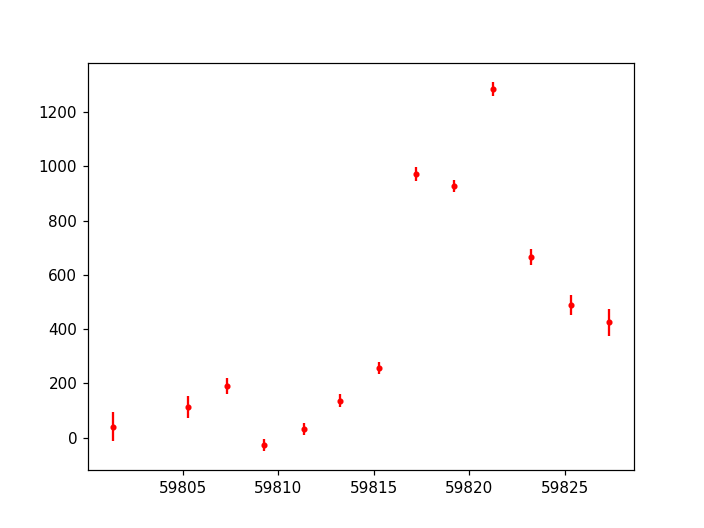

/astro/users/ykwang/.conda/envs/alert_demo/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<ErrorbarContainer object of 3 artists>

In [17]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_flux'],
             ztf_fp.loc[wg,'dc_flux_err'],fmt='.',ls='none', color='g')
plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_flux'],
             ztf_fp.loc[wr,'dc_flux_err'],fmt='.',ls='none', color='r')

In [18]:
colors = ['green', 'pink', 'red']

<IPython.core.display.Javascript object>


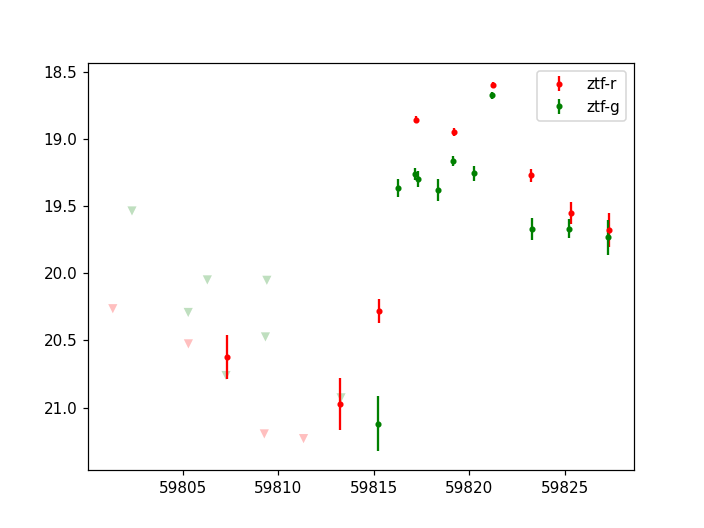

In [19]:
plt.figure()
wr = ztf_fp['filter'] == 'ZTF_r'
wg = ztf_fp['filter'] == 'ZTF_g'

plt.errorbar(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_mag'],
             ztf_fp.loc[wr,'dc_mag_err'],fmt='.',ls='none', color=colors[2], label='ztf-r')
plt.scatter(ztf_fp.loc[wr,'mjd'],ztf_fp.loc[wr,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[2])
plt.errorbar(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_mag'],
             ztf_fp.loc[wg,'dc_mag_err'],fmt='.',ls='none', color=colors[0], label='ztf-g')
plt.scatter(ztf_fp.loc[wg,'mjd'],ztf_fp.loc[wg,'dc_maglim'], marker='v',alpha=0.25,
            edgecolor='none',color=colors[0])

# plot cases without a reference
# plt.errorbar(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'dc_mag'],
#              ztf_fp.loc[wr&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[2])
# plt.scatter(ztf_fp.loc[wr&wnoref,'mjd'],ztf_fp.loc[wr&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#             edgecolor='none',color=colors[2])
# plt.errorbar(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'dc_mag'],
#              ztf_fp.loc[wg&wnoref,'dc_mag_err'],fmt='.',ls='none', color=colors[0])
# these no-ref limits seem to be spurious
#plt.scatter(ztf_fp.loc[wg&wnoref,'mjd'],ztf_fp.loc[wg&wnoref,'diffmaglim'], marker='v',alpha=0.25,
#            edgecolor='none',color=colors[0])

# TODO: consider marking bad points (procstatus !=0)
plt.legend()
plt.gca().invert_yaxis()

In [33]:
ztf_fp['utc'] = pd.to_datetime(ztf_fp['mjd'] + 2400000.5, unit='D', origin='julian').dt.strftime('%D-%T')

# Find Peak

In [40]:
print(ztf_fp.query('19.2 > dc_mag')[['filter', 'dc_snr', 'dc_mag', 'dc_mag_err', 'dc_maglim', 'mjd', 'utc']])

      filter     dc_snr     dc_mag  dc_mag_err  dc_maglim           mjd  \
index                                                                     
17     ZTF_r  40.172530  18.856640    0.027026        NaN  59817.211620   
20     ZTF_g        NaN  19.163790    0.039530        NaN  59819.171933   
21     ZTF_r  40.173535  18.947339    0.027025        NaN  59819.192651   
23     ZTF_g        NaN  18.674768    0.026822        NaN  59821.221377   
24     ZTF_r  50.350587  18.595807    0.021563        NaN  59821.235185   

                     utc  
index                     
17     08/26/22-05:04:44  
20     08/28/22-04:07:35  
21     08/28/22-04:37:25  
23     08/30/22-05:18:46  
24     08/30/22-05:38:40  


# Prior to alert trigger

all

In [43]:
print(ztf_fp.query('59805 < mjd < 59817')[['filter', 'dc_snr', 'dc_mag', 'dc_mag_err', 'dc_maglim', 'mjd', 'utc']])

      filter     dc_snr     dc_mag  dc_mag_err  dc_maglim           mjd  \
index                                                                     
2      ZTF_g        NaN        NaN         NaN  20.291250  59805.287789   
3      ZTF_r   2.870366        NaN         NaN  20.525123  59805.297500   
4      ZTF_g        NaN        NaN         NaN  20.048861  59806.289792   
5      ZTF_g        NaN        NaN         NaN  20.760620  59807.268391   
6      ZTF_r   6.524415  20.623175    0.166406        NaN  59807.312917   
7      ZTF_r  -1.285888        NaN         NaN  21.195417  59809.273484   
8      ZTF_g        NaN        NaN         NaN  20.473265  59809.332731   
9      ZTF_g        NaN        NaN         NaN  20.051829  59809.406632   
10     ZTF_r   1.520056        NaN         NaN  21.230545  59811.328507   
11     ZTF_r   5.575720  20.972557    0.194719        NaN  59813.242107   
12     ZTF_g        NaN        NaN         NaN  20.926655  59813.291806   
13     ZTF_g        NaN  

forced phot detections

In [52]:
print(ztf_fp.loc[ztf_fp['dc_maglim'].isna()].query('59805 < mjd < 59817')[['filter', 'dc_snr', 'dc_mag', 'dc_mag_err', 'dc_maglim', 'mjd', 'utc']])

      filter     dc_snr     dc_mag  dc_mag_err  dc_maglim           mjd  \
index                                                                     
6      ZTF_r   6.524415  20.623175    0.166406        NaN  59807.312917   
11     ZTF_r   5.575720  20.972557    0.194719        NaN  59813.242107   
13     ZTF_g        NaN  21.118602    0.207379        NaN  59815.239792   
14     ZTF_r  11.991155  20.279265    0.090542        NaN  59815.287836   
15     ZTF_g        NaN  19.365798    0.065914        NaN  59816.264583   

                     utc  
index                     
6      08/16/22-07:30:36  
11     08/22/22-05:48:38  
13     08/24/22-05:45:18  
14     08/24/22-06:54:28  
15     08/25/22-06:20:59  


nondetections

In [53]:
print(ztf_fp.loc[~ztf_fp['dc_maglim'].isna()].query('59805 < mjd < 59817')[['filter', 'dc_snr', 'dc_mag', 'dc_mag_err', 'mjd', 'utc']])

      filter    dc_snr  dc_mag  dc_mag_err           mjd                utc
index                                                                      
2      ZTF_g       NaN     NaN         NaN  59805.287789  08/14/22-06:54:25
3      ZTF_r  2.870366     NaN         NaN  59805.297500  08/14/22-07:08:24
4      ZTF_g       NaN     NaN         NaN  59806.289792  08/15/22-06:57:18
5      ZTF_g       NaN     NaN         NaN  59807.268391  08/16/22-06:26:28
7      ZTF_r -1.285888     NaN         NaN  59809.273484  08/18/22-06:33:49
8      ZTF_g       NaN     NaN         NaN  59809.332731  08/18/22-07:59:08
9      ZTF_g       NaN     NaN         NaN  59809.406632  08/18/22-09:45:32
10     ZTF_r  1.520056     NaN         NaN  59811.328507  08/20/22-07:53:02
12     ZTF_g       NaN     NaN         NaN  59813.291806  08/22/22-07:00:12


In [21]:
ztf_fp.query('59817 < mjd').groupby('filter')[['dc_mag', 'dc_mag_err']].count()

,dc_mag,dc_mag_err
filter,,
ZTF_g,9,9
ZTF_r,6,6


In [ ]:
59748.367581 + 2400000.5

In [ ]:
ztf_fp[ztf_fp['mjd'] > 59749][['filter', 'mjd']]

In [ ]:
pd.to_datetime(ztf_fp.set_index('filter').query('59743 < mjd')['mjd'] + 2400000.5, unit='D', origin='julian')

In [ ]:
np.sum(ztf_fp.dc_snr > 3)

In [ ]:
ztf_fp['dc_snr'].hist()

In [17]:
ztf_fp.iloc[-1]

field                            1483
ccdid                              13
qid                                 2
filter                          ZTF_r
pid                     1998417145015
infobitssci                         0
sciinpseeing                   1.8844
scibckgnd                     242.012
scisigpix                     9.43395
zpmaginpsci                   26.2502
zpmaginpsciunc             2.3525e-06
zpmaginpscirms              0.0141879
clrcoeff                    0.0769942
clrcoeffunc               6.56088e-06
ncalmatches                      1835
exptime                            30
adpctdif1                    0.064232
adpctdif2                    0.053677
diffmaglim                     20.299
zpdiff                        26.2502
programid                           2
jd                        2.45975e+06
rfid                       1483120250
forcediffimflux               153.099
forcediffimfluxunc            30.3836
forcediffimsnr                5.60515
forcediffimc